# Project 3: Classification of r/science and r/worldnews subreddit posts

### Author: Kirsty Hawke

### Purpose:  

Using Pushshift's API, posts from r/science and r/worldnews will be used to train a classifier on which subreddit a given post came from. This binary classification problem aims to illuminate the difference in general news reporting and scientific reporting. The past few years have highlighted the need for unbiased, clear journalism that does sensationalise stories for clickbait. We are all affected by what we read and irresponsible reporting can deepen divisions between people. Success for this project will be a +85% accuracy at classsifying posts correctly. 

Additionally, this will be an interesting way to analyze the different community members of each subreddit and how they communicate or respond to articles. Both subreddits post links and not the full articles.

The posts and comments are selected based on their scores, an attibute that conveys importance or agreement. How scoring works: "When you're logged in to Reddit, you'll be able to upvote and downvote items to help determine their rank. You get one vote per item, but you can change it after it's logged. The number appearing between the up and down arrows is the submission's score: the number of upvotes minus the number of downvotes."

### Background Research: 
https://www.vox.com/science-and-health/2019/6/11/18652225/hype-science-press-releases

https://www.vox.com/science-and-health/2017/3/3/14792174/half-scientific-studies-news-are-wrong

https://journalofethics.ama-assn.org/article/media-miss-key-points-scientific-reporting/2007-03

r/science description:
This community is a place to share and discuss new scientific research. Read about the latest advances in astronomy, biology, medicine, physics, social science, and more. Find and submit new publications and popular science coverage of current research.

r/worldnews decription:
A place for major news from around the world, excluding US-internal news.

### The Data Science Process

* Problem Statement
* Data Collection
* Data Cleaning & EDA
* Preprocessing & Modeling
* Evaluation and Conceptual Understanding
* Conclusion and Recommendations

## Importing Libraries

In [ ]:
from pmaw import PushshiftAPI
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import regex as re
import pandas as pd
import numpy as np

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [421]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import plot_confusion_matrix

##  Data Collection

Using pmaw to collect top 5000 top scoring posts and comments from each subreddit. Downloaded on 13/01/2022.


## For r/science

In [187]:
api = PushshiftAPI()
posts = api.search_submissions(subreddit="science", limit=5000,
                              sort_type ="score", filter="title")
print(f'Retrieved {len(posts)} submissions')

INFO:pmaw.PushshiftAPIBase:Total:: Success Rate: 100.00% - Requests: 59 - Batches: 6 - Items Remaining: 0
Retrieved 5000 submissions


In [188]:
post_list = [post for post in posts]
sc_post = pd.DataFrame(post_list)
sc_post.drop(columns = 'created_utc', inplace=True)

In [189]:
comms = api.search_comments(subreddit="science", limit=5000,
                              sort_type ="score", filter="body")

print(f'Retrieved {len(comms)} comments')
comm_list = [com for com in comms]
sc_comm = pd.DataFrame(comm_list)
sc_comm.drop(columns = 'created_utc', inplace=True)

INFO:pmaw.PushshiftAPIBase:Total:: Success Rate: 100.00% - Requests: 52 - Batches: 6 - Items Remaining: 0
Retrieved 5000 comments


In [190]:
sc_post['science'] = 1
sc_comm['science'] = 1

In [191]:
sc_post.head()

,title,science
0,A record number of firearm background checks w...,1
1,"Using deep convolutional neural networks, rese...",1
2,The 'one who causes fear' - a new carnivrous p...,1
3,Gratitude helps explain why increased zest for...,1
4,"In humans and dogs, a decline in semen quality...",1


In [192]:
sc_comm.head()

,body,science
0,In Sweden*\n\n&gt; The researchers submitted a...,1
1,Im pretty sure more young adults live with the...,1
2,[removed],1
3,How do young adults even date outside of highs...,1
4,This was a super important distinction,1


## For r/worldnews

In [193]:
posts = api.search_submissions(subreddit="worldnews", limit=5000,
                              sort_type ="score", filter="title")
print(f'Retrieved {len(posts)} submissions')

post_list = [post for post in posts]
wn_post = pd.DataFrame(post_list)
wn_post.drop(columns = 'created_utc', inplace=True)

comms = api.search_comments(subreddit="worldnews", limit=5000,
                              sort_type ="score", filter="body")
print(f'Retrieved {len(comms)} comments')

comm_list = [com for com in comms]
wn_comm = pd.DataFrame(comm_list)
wn_comm.drop(columns = 'created_utc', inplace=True)

wn_post['science'] = 0
wn_comm['science'] = 0

INFO:pmaw.PushshiftAPIBase:Total:: Success Rate: 100.00% - Requests: 52 - Batches: 6 - Items Remaining: 0
Retrieved 5000 submissions
INFO:pmaw.PushshiftAPIBase:Total:: Success Rate: 90.91% - Requests: 55 - Batches: 6 - Items Remaining: 0
Retrieved 5000 comments


In [194]:
wn_post.head()

,title,science
0,UAE announces relaxing of Islamic laws for per...,0
1,Four more Oath Keepers indicted in Jan. 6 fede...,0
2,Vote on Texas bill to make voting tougher bloc...,0
3,Huge parts of internet currently offline,0
4,Major media websites go down worldwide,0


In [195]:
wn_comm.head()

,body,science
0,The CIA concluded this over 2 years ago.,0
1,This is true. Some jackass told my friend to “...,0
2,[removed],0
3,I'm Canadian and follow the news and even I do...,0
4,"Syria got bombed quicker than you got your $2,...",0


In [196]:
wn_post['science'] = 0

In [197]:
wn_post_copy = wn_post
posts = wn_post_copy.append(sc_post)
posts.rename(columns= {'title':'body'}, inplace=True)
posts

,body,science
0,UAE announces relaxing of Islamic laws for per...,0
1,Four more Oath Keepers indicted in Jan. 6 fede...,0
2,Vote on Texas bill to make voting tougher bloc...,0
3,Huge parts of internet currently offline,0
4,Major media websites go down worldwide,0
...,...,...
4995,Alpha helices may form harmful deposits in the...,1
4996,A new fossil has offered scientists insights i...,1
4997,GOOVIS LITE: Crystal Clear Giant Screen Person...,1
4998,"Blood sample analysis showed that, two to five...",1


In [198]:
comments = wn_comm.append(sc_comm)
comments.reset_index(drop=True, inplace=True)
comments

,body,science
0,The CIA concluded this over 2 years ago.,0
1,This is true. Some jackass told my friend to “...,0
2,[removed],0
3,I'm Canadian and follow the news and even I do...,0
4,"Syria got bombed quicker than you got your $2,...",0
...,...,...
9995,"Alright fair enough i suppose, but consider wh...",1
9996,Pretty cool. I heard about this a couple years...,1
9997,"Outlawed in 1994, the problem is enforcement o...",1
9998,Oh yeah. People I know that got hit died or re...,1


In [199]:
both = comments.append(posts)
both.reset_index(drop=True, inplace=True)
both

,body,science
0,The CIA concluded this over 2 years ago.,0
1,This is true. Some jackass told my friend to “...,0
2,[removed],0
3,I'm Canadian and follow the news and even I do...,0
4,"Syria got bombed quicker than you got your $2,...",0
...,...,...
19995,Alpha helices may form harmful deposits in the...,1
19996,A new fossil has offered scientists insights i...,1
19997,GOOVIS LITE: Crystal Clear Giant Screen Person...,1
19998,"Blood sample analysis showed that, two to five...",1


In [200]:
posts.reset_index(drop=True, inplace=True)
posts

,body,science
0,UAE announces relaxing of Islamic laws for per...,0
1,Four more Oath Keepers indicted in Jan. 6 fede...,0
2,Vote on Texas bill to make voting tougher bloc...,0
3,Huge parts of internet currently offline,0
4,Major media websites go down worldwide,0
...,...,...
9995,Alpha helices may form harmful deposits in the...,1
9996,A new fossil has offered scientists insights i...,1
9997,GOOVIS LITE: Crystal Clear Giant Screen Person...,1
9998,"Blood sample analysis showed that, two to five...",1


##  Data Cleaning & EDA

In [201]:
# emojis
EMOJI_PATTERN = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
def cleaning(text):

    #lowercase all characters
    text = text.lower()
    
    #remove links
    text = re.sub('https?://\S+|www\.\S+', '', text) 
    
    #Remove special characters
    text = re.sub('<.*?>+', '', text) 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
    text = re.sub('[„»â€™]', '', text)

    #remove emojis
    text = EMOJI_PATTERN.sub(r'', text) 

    text_tokens = word_tokenize(text)
    filtered_sentence = (" ").join(text_tokens)
    text = filtered_sentence

    return text #return cleaned sentences

In [202]:
posts_copy = posts['body'].apply(cleaning)
posts['body'] = posts_copy

In [203]:
posts.head()

,body,science
0,uae announces relaxing of islamic laws for per...,0
1,four more oath keepers indicted in jan 6 feder...,0
2,vote on texas bill to make voting tougher bloc...,0
3,huge parts of internet currently offline,0
4,major media websites go down worldwide,0


In [204]:
comments_copy = comments['body'].apply(cleaning)
comments['body'] = comments_copy

In [205]:
both_copy = both['body'].apply(cleaning)
both['body'] = both_copy

In [206]:
#Save dataframes to csv
posts.to_csv('posts.csv', index=False)
comments.to_csv('comments.csv', index=False)  
both.to_csv('both.csv', index=False)  

In [207]:
X_p = posts['body']
y_p = posts['science']

In [208]:
X_c = comments['body']
y_c = comments['science']

In [209]:
X_cp = both['body']
y_cp = both['science']

In [210]:
y_p.value_counts(normalize=True) #baseline accuracy of 0.5

1    0.5
0    0.5
Name: science, dtype: float64

### Word Cloud

In [211]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import figure

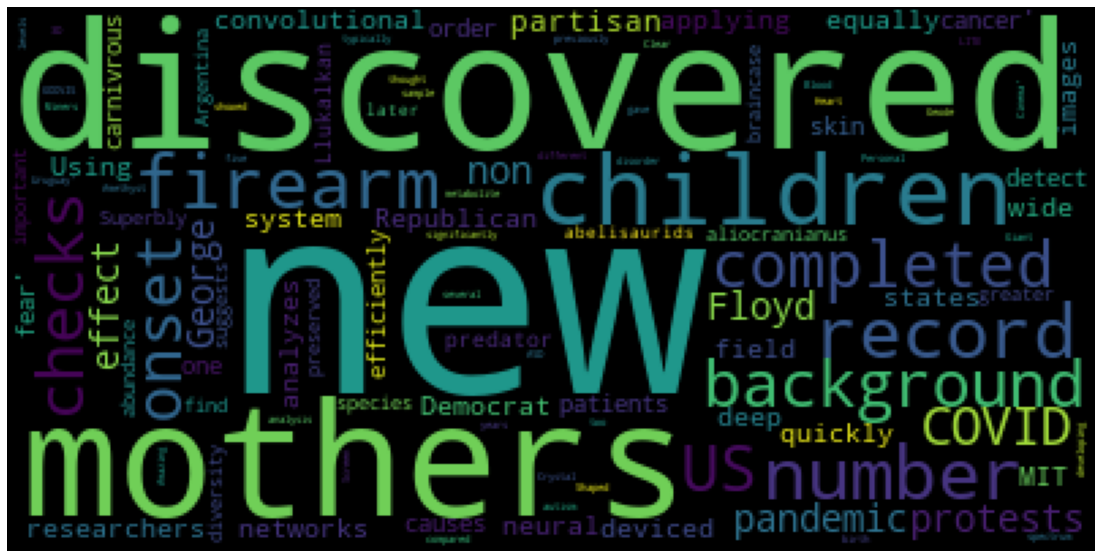

In [212]:
#Modified from https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe

text = sc_post.values 
wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

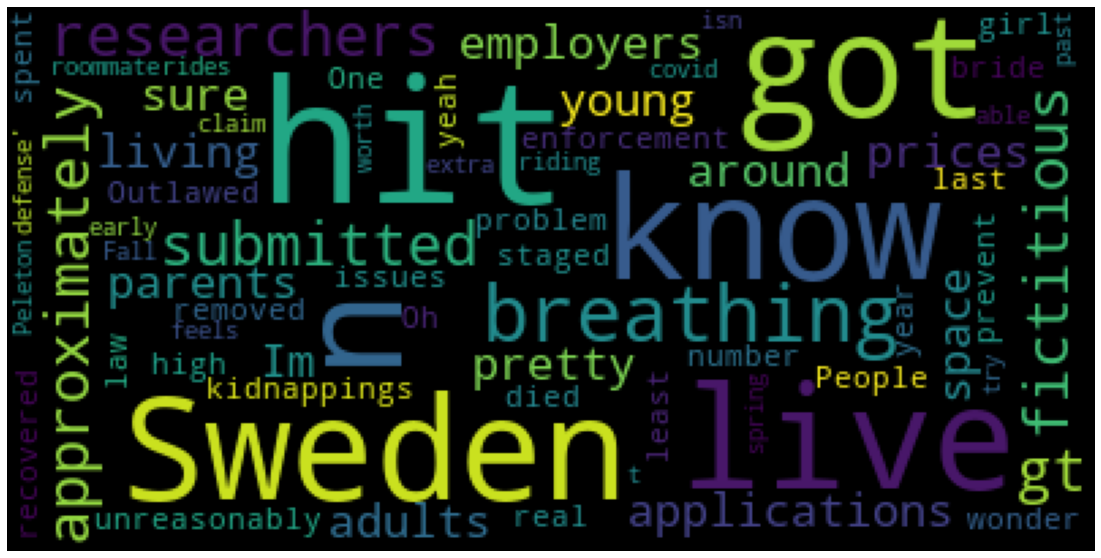

In [213]:
text = sc_comm['body'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

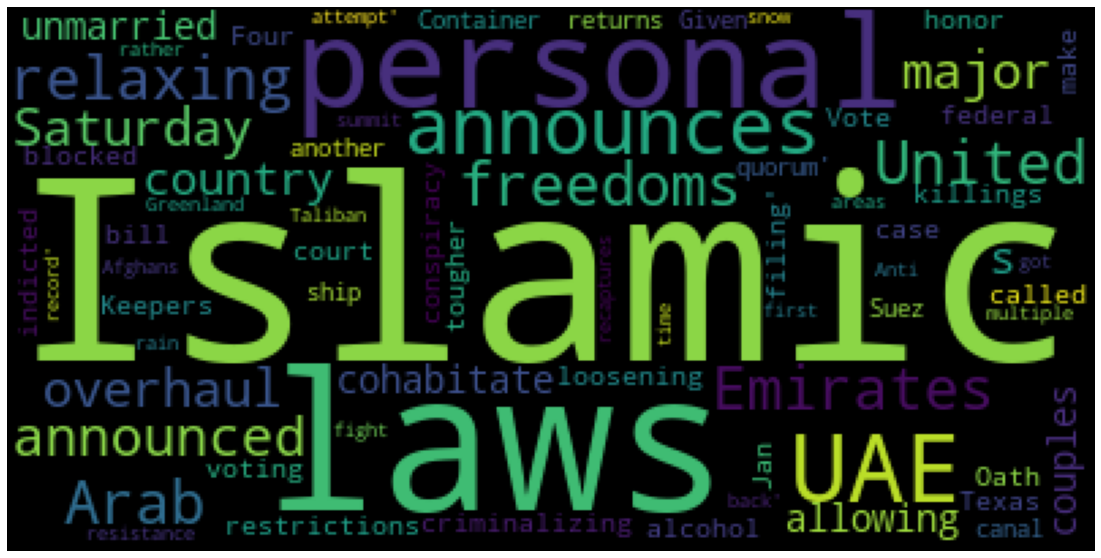

In [215]:
text = wn_post.values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

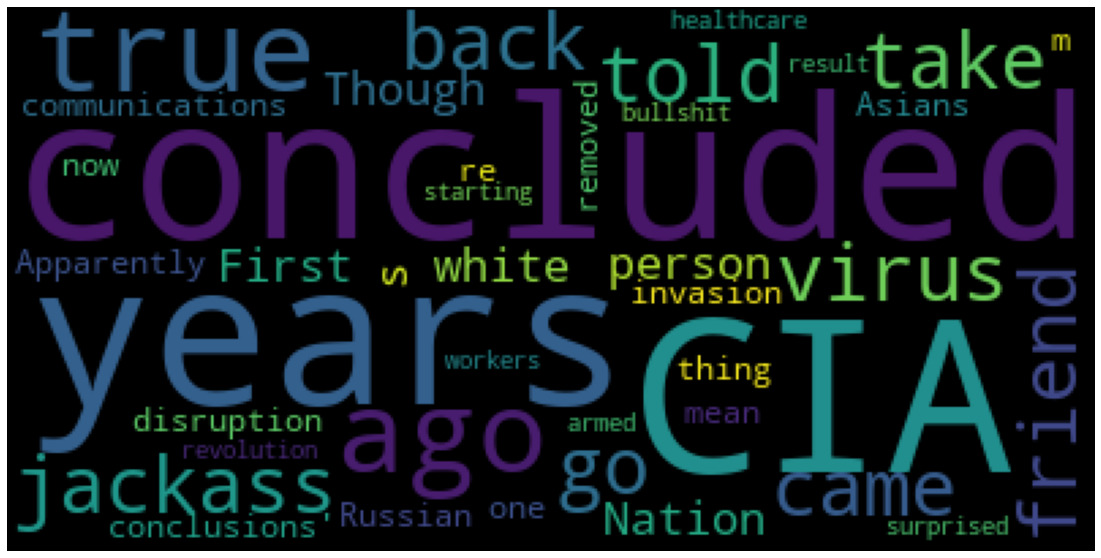

In [216]:
text = wn_comm['body'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

Based on the word clouds, it seems that the subreddits are different enough to be distinguishable. 

##  Preprocessing & Modeling

## Model Instatiation

In [242]:
lr = LogisticRegression(solver='liblinear')

In [244]:
mnb = MultinomialNB()

In [245]:
knn = KNeighborsClassifier(n_neighbors=61, n_jobs=-1) #Based on sqrt(n_samples)

In [246]:
rf = RandomForestClassifier(n_estimators=61, n_jobs=-1) #Based on sqrt(n_samples)

In [247]:
et = ExtraTreesClassifier(n_estimators=61, n_jobs=-1)

In [249]:
svc = SVC()

In [251]:
ada = AdaBoostClassifier()

## Model Evaluation - CountVectorizer

In [252]:
cvec = CountVectorizer()
cvec.fit(X_p)
X_p_cv = cvec.transform(X_p)
X_p_cv

<10000x18371 sparse matrix of type '<class 'numpy.int64'>'
	with 149196 stored elements in Compressed Sparse Row format>

In [253]:
cvec = CountVectorizer()
cvec.fit(X_c)
X_c_cv = cvec.transform(X_c)
X_c_cv

<10000x22259 sparse matrix of type '<class 'numpy.int64'>'
	with 262101 stored elements in Compressed Sparse Row format>

In [254]:
cvec = CountVectorizer()
cvec.fit(X_cp)
X_cp_cv = cvec.transform(X_cp)
X_cp_cv

<20000x31264 sparse matrix of type '<class 'numpy.int64'>'
	with 411297 stored elements in Compressed Sparse Row format>

In [448]:
# Create train_test_split.
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p_cv,
                                                    y_p,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                   stratify=y_p)

In [449]:
# Create train_test_split.
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c_cv,
                                                    y_c,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                   stratify=y_c)

In [450]:
# Create train_test_split.
X_train_cp, X_test_cp, y_train_cp, y_test_cp = train_test_split(X_cp_cv,
                                                    y_cp,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                   stratify=y_cp)

In [258]:
print('Logistic Regression')
print(f"CV Post score: {cross_val_score(lr, X_train_p, y_train_p, cv=5).mean()}")
print(f"CV Comment score: {cross_val_score(lr, X_train_c, y_train_c, cv=5).mean()}")
print(f"CV Both score: {cross_val_score(lr, X_train_cp, y_train_cp, cv=5).mean()}")
print()

print('Multinomial Naive Bayes')
print(f"CV Post score: {cross_val_score(mnb, X_train_p, y_train_p, cv=5).mean()}")
print(f"CV Comment score: {cross_val_score(mnb, X_train_c, y_train_c, cv=5).mean()}")
print(f"CV Both score: {cross_val_score(mnb, X_train_cp, y_train_cp, cv=5).mean()}")
print()

print('KNN')
print(f"CV Post score: {cross_val_score(knn, X_train_p, y_train_p, cv=5).mean()}")
print(f"CV Comment score: {cross_val_score(knn, X_train_c, y_train_c, cv=5).mean()}")
print(f"CV Both score: {cross_val_score(knn, X_train_cp, y_train_cp, cv=5).mean()}")
print()

print('Random Forest')
print(f"CV Post score: {cross_val_score(rf, X_train_p, y_train_p, cv=5).mean()}")
print(f"CV Comment score: {cross_val_score(rf, X_train_c, y_train_c, cv=5).mean()}")
print(f"CV Both score: {cross_val_score(rf, X_train_cp, y_train_cp, cv=5).mean()}")
print()

print('Extra Trees')
print(f"CV Post score: {cross_val_score(et, X_train_p, y_train_p, cv=5).mean()}")
print(f"CV Coment score: {cross_val_score(et, X_train_c, y_train_c, cv=5).mean()}")
print(f"CV Both score: {cross_val_score(et, X_train_cp, y_train_cp, cv=5).mean()}")

Logistic Regression
CV Post score: 0.9103999999999999
CV Comment score: 0.8070666666666668
CV Both score: 0.857

Multinomial Naive Bayes
CV Post score: 0.9141333333333334
CV Comment score: 0.8177333333333333
CV Both score: 0.8615999999999999

KNN
CV Post score: 0.6225333333333334
CV Comment score: 0.5048
CV Both score: 0.5980666666666666

Random Forest
CV Post score: 0.8870666666666667
CV Comment score: 0.7893333333333332
CV Both score: 0.8459333333333333

Extra Trees
CV Post score: 0.9026666666666665
CV Coment score: 0.8064
CV Both score: 0.8547333333333332


In [259]:
print('ADA Boosting')
print(f"CV Post score: {cross_val_score(ada, X_train_p, y_train_p, cv=5).mean()}")
print(f"CV Comment score: {cross_val_score(ada, X_train_c, y_train_c, cv=5).mean()}")
print(f"CV Both score: {cross_val_score(ada, X_train_cp, y_train_cp, cv=5).mean()}")

ADA Boosting
CV Post score: 0.7769333333333334
CV Comment score: 0.7041333333333333
CV Both score: 0.7230000000000001


In [260]:
print('SV Machine')
print(f"CV Post score: {cross_val_score(svc, X_train_p, y_train_p, cv=5).mean()}")
print(f"CV Comment score: {cross_val_score(svc, X_train_c, y_train_c, cv=5).mean()}")
print(f"CV Both score: {cross_val_score(svc, X_train_cp, y_train_cp, cv=5).mean()}")

SV Machine
CV Post score: 0.8857333333333333
CV Comment score: 0.7418666666666666
CV Both score: 0.8230666666666668


## Model Evaluation - TFIDFVectorizer

This works in a similar way to CVEC but it assigns words a score instead of a count which can give some words mre weight in shorter entries.

In [261]:
tvec = TfidfVectorizer()
tvec.fit(X_p)
X_p_tv= tvec.transform(X_p)
X_p_tv

<10000x18371 sparse matrix of type '<class 'numpy.float64'>'
	with 149196 stored elements in Compressed Sparse Row format>

In [262]:
tvec = TfidfVectorizer()
tvec.fit(X_c)
X_c_tv = tvec.transform(X_c)
X_c_tv

<10000x22259 sparse matrix of type '<class 'numpy.float64'>'
	with 262101 stored elements in Compressed Sparse Row format>

In [263]:
tvec = TfidfVectorizer()
tvec.fit(X_cp)
X_cp_tv = tvec.transform(X_cp)
X_cp_tv

<20000x31264 sparse matrix of type '<class 'numpy.float64'>'
	with 411297 stored elements in Compressed Sparse Row format>

In [264]:
# Create train_test_split.
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p_tv,
                                                    y_p,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                   stratify=y_p)

In [265]:
# Create train_test_split.
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c_tv,
                                                    y_c,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                   stratify=y_c)

In [266]:
# Create train_test_split.
X_train_cp, X_test_cp, y_train_cp, y_test_cp = train_test_split(X_cp_tv,
                                                    y_cp,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                   stratify=y_cp)

In [267]:
print('Logistic Regression')
print(f"TV Post score: {cross_val_score(lr, X_train_p, y_train_p, cv=5).mean()}")
print(f"TV Comment score: {cross_val_score(lr, X_train_c, y_train_c, cv=5).mean()}")
print(f"TV Both score: {cross_val_score(lr, X_train_cp, y_train_cp, cv=5).mean()}")
print()

print('Multinomial Naive Bayes')
print(f"TV Post score: {cross_val_score(mnb, X_train_p, y_train_p, cv=5).mean()}")
print(f"TV Comment score: {cross_val_score(mnb, X_train_c, y_train_c, cv=5).mean()}")
print(f"TV Both score: {cross_val_score(mnb, X_train_cp, y_train_cp, cv=5).mean()}")
print()

print('KNN')
print(f"TV Post score: {cross_val_score(knn, X_train_p, y_train_p, cv=5).mean()}")
print(f"TV Comment score: {cross_val_score(knn, X_train_c, y_train_c, cv=5).mean()}")
print(f"TV Both score: {cross_val_score(knn, X_train_cp, y_train_cp, cv=5).mean()}")
print()

print('Random Forest')
print(f"TV Post score: {cross_val_score(rf, X_train_p, y_train_p, cv=5).mean()}")
print(f"TV Comment score: {cross_val_score(rf, X_train_c, y_train_c, cv=5).mean()}")
print(f"TV Both score: {cross_val_score(rf, X_train_cp, y_train_cp, cv=5).mean()}")
print()

print('Extra Trees')
print(f"TV Post score: {cross_val_score(et, X_train_p, y_train_p, cv=5).mean()}")
print(f"TV Coment score: {cross_val_score(et, X_train_c, y_train_c, cv=5).mean()}")
print(f"TV Both score: {cross_val_score(et, X_train_cp, y_train_cp, cv=5).mean()}")

Logistic Regression
TV Post score: 0.8961333333333334
TV Comment score: 0.7858666666666666
TV Both score: 0.8450666666666666

Multinomial Naive Bayes
TV Post score: 0.9128000000000001
TV Comment score: 0.8218666666666665
TV Both score: 0.8628

KNN
TV Post score: 0.7585333333333334
TV Comment score: 0.7404
TV Both score: 0.5892666666666667

Random Forest
TV Post score: 0.8881333333333332
TV Comment score: 0.7845333333333333
TV Both score: 0.8402666666666667

Extra Trees
TV Post score: 0.9033333333333333
TV Coment score: 0.8010666666666667
TV Both score: 0.8562


In [268]:
print('ADA Boosting')
print(f"TV Post score: {cross_val_score(ada, X_train_p, y_train_p, cv=5).mean()}")
print(f"TV Comment score: {cross_val_score(ada, X_train_c, y_train_c, cv=5).mean()}")
print(f"TV Both score: {cross_val_score(ada, X_train_cp, y_train_cp, cv=5).mean()}")

ADA Boosting
TV Post score: 0.7869333333333334
TV Comment score: 0.6966666666666667
TV Both score: 0.7269333333333334


In [269]:
print('SV Machine')
print(f"TV Post score: {cross_val_score(svc, X_train_p, y_train_p, cv=5).mean()}")
print(f"TV Comment score: {cross_val_score(svc, X_train_c, y_train_c, cv=5).mean()}")
print(f"TV Both score: {cross_val_score(svc, X_train_cp, y_train_cp, cv=5).mean()}")

SV Machine
TV Post score: 0.9150666666666666
TV Comment score: 0.8104000000000001
TV Both score: 0.8659333333333332


### Summary of Initial Scores

| Model                   | Vectorizer | Post Score | Comments Score | Both Score |
| ----------------------- | ---------- | ---------- | -------------- | ---------- |
| Logistic Regression     | Count      | 0.9104     | 0.8071         | 0.8570     |
| Logistic Regression     | TFIDF      | 0.8961     | 0.7859     | 0.8451         |
| Multinomial Naïve Bayes | Count      | 0.9141     | 0.8177         | 0.8616     |
| Multinomial Naïve Bayes| TFIDF                   | 0.9128     | 0.8219     | 0.8628         |
| KNN                     | Count      | 0.6225     | 0.5048         | 0.5981     |
| KNN                     | TFIDF                   | 0.7585     | 0.7404     | 0.5893         |
| Random Forest           | Count      | 0.8871     | 0.7893         | 0.8459     |
| Random Forest           | TFIDF                   | 0.8881     | 0.7845     | 0.8403         |
| Extra Trees             | Count      | 0.9027     | 0.8064         | 0.8547     |
| Extra Trees             | TFIDF                   | 0.9033     | 0.8011     | 0.8562         |
| AdaBoost                | Count      | 0.7769     | 0.7041         | 0.7230     |
| AdaBoost| TFIDF                   | 0.7869     | 0.6967     | 0.7269         |
| SVC                     | Count      | 0.8857     | 0.7419         | 0.8231     |
| SVC| TFIDF                   | 0.9151     | 0.8104     | 0.8659         |
|                         |            |            |                |            |
|                         | Max Score  | 0.9151     | 0.8219         | 0.8659     |

Clearly, the posts only dataset gives the best scores. In that subset, the highest r^2 scores came from the SVC model with TFIDFVectorize and then the Multinomial Naive Bayes Model. Both will now be tuned for the best hyperparameters.

## Train/Test Split

In [270]:
# Create train_test_split.
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p,
                                                    y_p,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                   stratify=y_p)

In [271]:
# Create train_test_split.
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c,
                                                    y_c,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                   stratify=y_c)

In [272]:
# Create train_test_split.
X_train_cp, X_test_cp, y_train_cp, y_test_cp = train_test_split(X_cp,
                                                    y_cp,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                   stratify=y_cp)

## Analyzers

In [273]:
#Instantiate stemmers and lematizer
p_stemmer = PorterStemmer() #Least strict stemmer
s_stemmer = SnowballStemmer(language='english') 
l_stemmer = LancasterStemmer() #Most strict stemmer
lemmatizer = WordNetLemmatizer() #keeps meaning of word intact

analyzer = CountVectorizer().build_analyzer()

#Analyzer functions
def stemmed_snow(doc):
    return (s_stemmer.stem(w) for w in analyzer(doc))

def stemmed_porter(doc):
    return (p_stemmer.stem(w) for w in analyzer(doc))

def stemmed_lancaster(doc):
    return (l_stemmer.stem(w) for w in analyzer(doc))

def lemmed(doc):
    return (lemmatizer.lemmatize(w) for w in analyzer(doc))

## Stop Words

Three options: NLTK stopwords, the inbuilt english stopwords or no stopwords

In [274]:
import nltk
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
print(sw_nltk)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Grid Search

Most promising models from preliminary evaluation: SVC & MNB

### Multinomial Naive Bayes - Posts Dataset - CountVectorizer

In [379]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [382]:
pipe_params = {
     'cvec__max_features' : [None, 5000, 10000, 20000], 
     'cvec__min_df' : [1, 0.25, 0.75], 
     'cvec__max_df' : [1.0, 0.25, 0.75],
     'cvec__ngram_range' : [(1,1)], # Also tried (1,2)
     'cvec__stop_words' : [None], #Also tried sw_ntlk and 'english'
     'cvec__analyzer' : [None, lemmed, stemmed_snow, stemmed_lancaster], 
     'mnb__alpha' : [2, 1, 0.1]
}

In [383]:
gs = GridSearchCV(pipe,param_grid = pipe_params, cv=3, verbose = 1, n_jobs = -1)
gs.fit(X_train_p, y_train_p)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 24.6min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__analyzer': [None,
                                            <function lemmed at 0x000001782FA7C040>,
                                            <function stemmed_snow at 0x000001782F9B7D30>,
                                            <function stemmed_lancaster at 0x000001782F9B74C0>],
                         'cvec__max_df': [1.0, 0.25, 0.75],
                         'cvec__max_features': [None, 5000, 10000, 20000],
                         'cvec__min_df': [1, 0.25, 0.75],
                         'cvec__ngram_range': [(1, 1)],
                         'cvec__stop_words': [None],
                         'mnb__alpha': [2, 1, 0.1]},
             verbose=1)

In [384]:
print(f"Best score: {gs.best_score_}")
gs_model = gs.best_estimator_
gs.best_params_

Best score: 0.9116


{'cvec__analyzer': <function __main__.lemmed(doc)>,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'mnb__alpha': 0.1}

In [385]:
pred_multinomial = gs_model.predict(X_test_p)
print(f"Train Score: {gs_model.score(X_train_p, y_train_p)}")
print(f"Test Score: {gs_model.score(X_test_p, y_test_p)}")

Train Score: 0.9674666666666667
Test Score: 0.9168


In [386]:
tn, fp, fn, tp = confusion_matrix(y_test_p, pred_multinomial).ravel()
print(f"True Negatives: {tn}")
print(f"Fale Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 1126
Fale Positives: 124
False Negatives: 84
True Positives: 1166


In [387]:
Accuracy = (tp+tn)/(tp+fp+fn+tn)
print(f"Accuracy: {Accuracy}")

Accuracy: 0.9168


**************************
Further tuning:

In [403]:
pipe_params = {
     'cvec__max_features' : [10000, 20000], 
#     'cvec__min_df' : [10, 100], 
     'cvec__max_df' : [0.95, 0.98],
#     'cvec__ngram_range' : [(1,1)], # Also tried (1,2)
     'cvec__stop_words' : [None], #Also tried sw_ntlk and 'english'
     'cvec__analyzer' : [lemmed], 
     'mnb__alpha' : [1]
}

In [404]:
gs = GridSearchCV(pipe,param_grid = pipe_params, cv=3, verbose = 1, n_jobs = -1)
gs.fit(X_train_p, y_train_p)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   13.3s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   14.9s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__analyzer': [<function lemmed at 0x000001782FA7C040>],
                         'cvec__max_df': [0.95, 0.98],
                         'cvec__max_features': [10000, 20000],
                         'cvec__stop_words': [None], 'mnb__alpha': [1]},
             verbose=1)

In [405]:
print(f"Best score: {gs.best_score_}")
gs_model = gs.best_estimator_
gs.best_params_

Best score: 0.9081333333333333


{'cvec__analyzer': <function __main__.lemmed(doc)>,
 'cvec__max_df': 0.95,
 'cvec__max_features': 20000,
 'cvec__stop_words': None,
 'mnb__alpha': 1}

In [406]:
pred_multinomial = gs_model.predict(X_test_p)
print(f"Train Score: {gs_model.score(X_train_p, y_train_p)}")
print(f"Test Score: {gs_model.score(X_test_p, y_test_p)}")

Train Score: 0.952
Test Score: 0.9208


In [407]:
tn, fp, fn, tp = confusion_matrix(y_test_p, pred_multinomial).ravel()
print(f"True Negatives: {tn}")
print(f"Fale Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 1120
Fale Positives: 130
False Negatives: 68
True Positives: 1182


In [408]:
Accuracy = (tp+tn)/(tp+fp+fn+tn)
print(f"Accuracy: {Accuracy}")

Accuracy: 0.9208


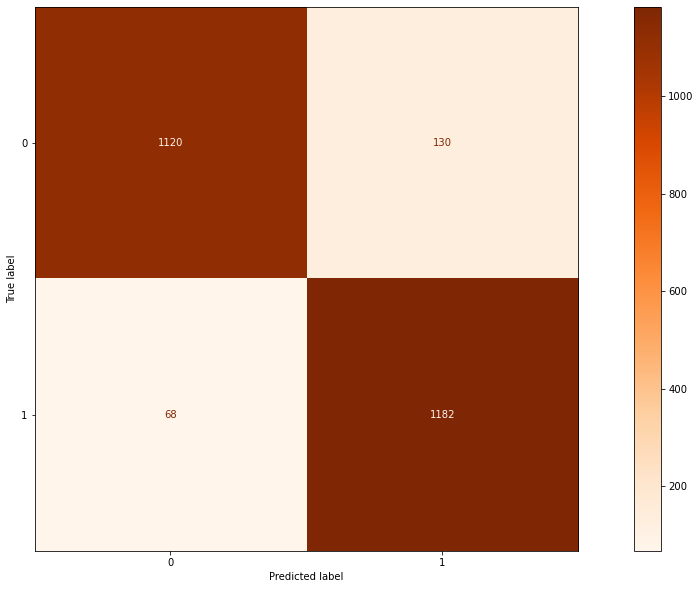

In [424]:
plot_confusion_matrix(gs, X_test_p, y_test_p, cmap = 'Oranges')  
plt.show()

### Support Vector Classification - Posts Dataset - TFIDFVectorizer

In [409]:
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC())
])

In [410]:
pipe_params2 = {
     'tvec__max_features' : [10000, 20000], 
     'tvec__min_df' : [10, 100], 
     'tvec__max_df' : [0.95, 0.98],
#     'tvec__ngram_range' : [(1,1)], #Also tried (1,2), (1,3)
#     'tvec__stop_words' : [None], #After testing multiple times stop words were never in best params
     'tvec__analyzer' : [None, lemmed, stemmed_snow, stemmed_lancaster], #After testing porter never chosen, eliminated to save time training
    
#      'svc__C': [1],
#      'svc__gamma': [2],
}

In [411]:
gs2 = GridSearchCV(pipe2,param_grid = pipe_params2, cv=3, verbose = 1, n_jobs = -1)
gs2.fit(X_train_p, y_train_p)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  5.3min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'tvec__analyzer': [None,
                                            <function lemmed at 0x000001782FA7C040>,
                                            <function stemmed_snow at 0x000001782F9B7D30>,
                                            <function stemmed_lancaster at 0x000001782F9B74C0>],
                         'tvec__max_df': [0.95, 0.98],
                         'tvec__max_features': [10000, 20000],
                         'tvec__min_df': [10, 100]},
             verbose=1)

In [412]:
print(f"Best score: {gs2.best_score_}")
gs2_model = gs2.best_estimator_
gs2.best_params_

Best score: 0.9058666666666667


{'tvec__analyzer': <function __main__.stemmed_snow(doc)>,
 'tvec__max_df': 0.95,
 'tvec__max_features': 10000,
 'tvec__min_df': 10}

In [413]:
pred_svc = gs2_model.predict(X_test_p)
print(f"Train Score: {gs2_model.score(X_train_p, y_train_p)}")
print(f"Test Score: {gs2_model.score(X_test_p, y_test_p)}")

Train Score: 0.9829333333333333
Test Score: 0.9208


In [417]:
tn, fp, fn, tp = confusion_matrix(y_test_p, pred_svc).ravel()
print(f"True Negatives: {tn}")
print(f"Fale Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 1152
Fale Positives: 98
False Negatives: 100
True Positives: 1150


In [418]:
Accuracy = (tp+tn)/(tp+fp+fn+tn)
print(f"Accuracy: {Accuracy}")

Accuracy: 0.9208


Further tuning:

In [437]:
pipe_params2 = {
     'tvec__max_features' : [10000], 
     'tvec__min_df' : [10], 
     'tvec__max_df' : [0.95],
#     'tvec__ngram_range' : [(1,1)], #Also tried (1,2), (1,3)
#     'tvec__stop_words' : [None], #After testing multiple times stop words were never in best params
     'tvec__analyzer' : [stemmed_snow], #After testing porter never chosen, eliminated to save time training
    
      'svc__C': [0.8, 0.9],
      'svc__gamma': [2],
}

In [438]:
gs2 = GridSearchCV(pipe2,param_grid = pipe_params2, cv=3, verbose = 1, n_jobs = -1)
gs2.fit(X_train_p, y_train_p)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   25.4s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.8, 0.9], 'svc__gamma': [2],
                         'tvec__analyzer': [<function stemmed_snow at 0x000001782F9B7D30>],
                         'tvec__max_df': [0.95], 'tvec__max_features': [10000],
                         'tvec__min_df': [10]},
             verbose=1)

In [439]:
print(f"Best score: {gs2.best_score_}")
gs2_model = gs2.best_estimator_
gs2.best_params_

Best score: 0.9089333333333333


{'svc__C': 0.9,
 'svc__gamma': 2,
 'tvec__analyzer': <function __main__.stemmed_snow(doc)>,
 'tvec__max_df': 0.95,
 'tvec__max_features': 10000,
 'tvec__min_df': 10}

In [440]:
pred_svc = gs2_model.predict(X_test_p)
print(f"Train Score: {gs2_model.score(X_train_p, y_train_p)}")
print(f"Test Score: {gs2_model.score(X_test_p, y_test_p)}")

Train Score: 0.9898666666666667
Test Score: 0.926


In [441]:
tn, fp, fn, tp = confusion_matrix(y_test_p, pred_svc).ravel()
print(f"True Negatives: {tn}")
print(f"Fale Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 1159
Fale Positives: 91
False Negatives: 94
True Positives: 1156


In [442]:
Accuracy = (tp+tn)/(tp+fp+fn+tn)
print(f"Accuracy: {Accuracy}")

Accuracy: 0.926


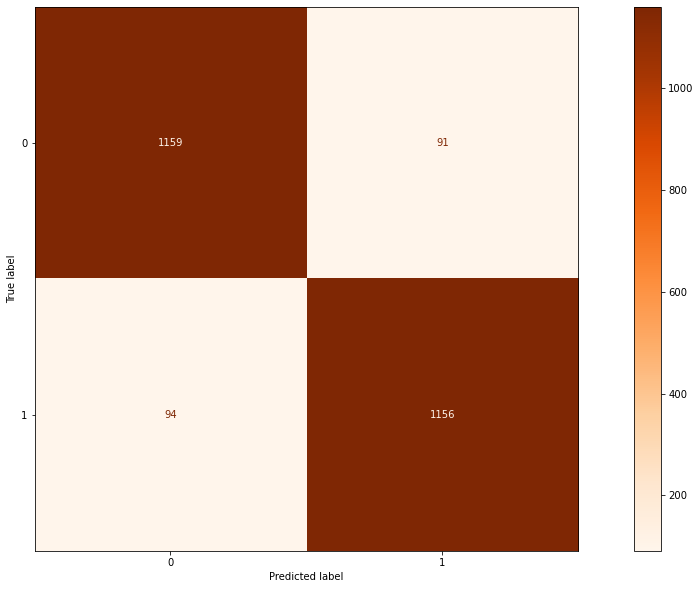

In [443]:
plot_confusion_matrix(gs2, X_test_p, y_test_p, cmap = 'Oranges')  
plt.show()

## Results Table

| Model    | Vectorizor | Parameters | CV Score | Train Score | Test Score | Accuracy |
| -------- | ---------- | ---------- | -------- | ----------- | ---------- | --------- |
| MNB      | Count      | analyzer = lemmed, max_df: 0.95, max_features: 20000, stop_words: None, alpha: 1|0.9141  |  0.952 |  0.9208  | 92.1% |
| SVC | TFIDF   |C = 0.9, gamma = 2,analyzer = stemmed_snow, max_df = 0.95, max_features = 10000, min_df = 10| 0.9151   |  0.9898 | 0.926 | 92.6% |

##  Evaluation & Conclusion

Compared to the baseline score of 0.5, these two models both exceed that and meet the original goal from the problem statement of having a classifier above 85% accurate. Clearly, the two subreddits are distinguishable by the language used and topics focussed on. 

Both models have a fairly low bias, however both still have a variance over 2%. While the multinomial naive bayes has a higher bias, it does have a lower variance. Depending on the needs of the user, either model would be suitable.

From the confusion matrix, SVC had a more even distribution of false posisitves and false negatives thus I have chosen that model to be the selected one. This model could help journalists sift out common ways on prasing science reporting versus general reporting. Additionally this method can be applied to other subreddits with possibly different models working better for different communities. 

In the future, this project could be further tuned to give better results with better computation power. Additionally, exploring a neural network for this classification problem could proove beneficial.